In [0]:
#Importing libraries.
import numpy as np
import random as rnd
from matplotlib import pyplot as plt
import math
import time

plt.style.use('seaborn')
plt.style.use('seaborn-bright')
plt.style.use('seaborn-white')

initial:  ['ME', 'S4', 'S2', 'S3', 'S5', 'M2', 'M4', 'S1', 'M5', 'M1', 'M3']
Parameters learned. T =  4637.679613139873 , alpha =  0.9911990572332205
Execution time:  6.430704355239868
[['XX' 'XX' 'XX' 'XX' 'XX' 'XX' 'XX' 'XX' 'XX']
 ['XX' 'ME' '12' '13' '14' '15' '16' '17' 'XX']
 ['XX' '21' '22' '23' '24' 'M1' 'XX' '27' 'XX']
 ['XX' '31' '32' 'S1' '34' 'XX' 'M3' 'XX' 'XX']
 ['XX' '41' '42' '43' '44' 'M5' '46' 'S5' 'XX']
 ['XX' '51' '52' 'M2' '54' '55' '56' 'S4' 'XX']
 ['XX' '61' '62' '63' 'S2' '65' '66' '67' 'XX']
 ['XX' 'S3' '72' '73' '74' 'M4' '76' '77' 'XX']
 ['XX' 'XX' 'XX' 'XX' 'XX' 'XX' 'XX' 'XX' 'XX']]
best cost:  35.0
best sequence:  ['ME' 'S3' 'S2' 'S5' 'S4' 'M4' 'M2' 'S1' 'M1' 'M5' 'M3']


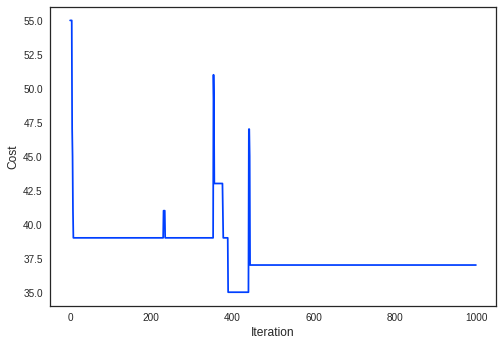

In [6]:
#Simulated annealing

actions = [0, 1, 2, 3] #up, right, down, left

empty = '.'
obstacle = 'XX'
generalContent = [empty, obstacle]

#Define symbols for swords and monsters.
#(when constructing an own grid with predetermined nr. of swords/monster, please adjust variable numberOfSwords)
numberOfSwords = 5
numberOfMonsters = numberOfSwords
total = range(1, numberOfSwords + 1)
swords = ['S' + str(x) for x in total]
monsters = ['M' + str(x) for x in total]
swords = swords[::-1]
monsters = monsters[::-1]

# Generate a grid with walls around and hero starting at (1,1). Note that it is not necessarily a valid grid.
def generateGrid(gridSize, numberOfObstacles):
  swordList = list(np.copy(swords))
  monsterList = list(np.copy(monsters))
  grid =  np.full((gridSize + 2, gridSize + 2), '..')
  for i in range(len(grid)):
    for j in range(len(grid)):
      grid[i][j] = str(i) + str(j)
  grid[0] = np.full(gridSize + 2, obstacle)
  grid[gridSize + 1] = np.full(gridSize + 2, obstacle)
  for j in range(0, gridSize + 2):
    grid[j][0] = obstacle
    grid[j][gridSize + 1] = obstacle
    
  grid[1, 1] = 'ME' # hero
  
  freePositions = [] 
  #create list of (x,y) where we can put swords/monsters
  for x in range(1, gridSize + 1):
    for y in range(1, gridSize + 1):
      if (grid[x][y] != obstacle and (x == 1 and y == 1) == False):
        freePositions.append((x, y))
  rnd.shuffle(freePositions)

  # put down all the weapons
  for i in range(numberOfSwords):
    if len(freePositions) == 0:
      break
    (x, y) = freePositions.pop()
    grid[x][y] = swordList.pop()

  # put down all the monsters
  for i in range(numberOfMonsters):
    if len(freePositions) == 0:
      break
    (x, y) = freePositions.pop()
    grid[x][y] = monsterList.pop()

  # put down obstaclesNum obstacles
  for i in range(numberOfObstacles):
    if len(freePositions) == 0:
      break
    (x, y) = freePositions.pop()
    grid[x][y] = obstacle
  return grid

#Transform the grid to a graph where edge exists between cells which can be reached one from another in one move (obstacles not included).
def gridToGraph(grid):
  width = len(grid) - 1
  height = len(grid) - 1
  graphOfGrid = []
  for x in range(1, len(grid) - 1):
    for y in range(1, len(grid) - 1): 
      if grid[x, y] != obstacle:
        index = rowColumnToIndex(x, y, width) 
        neighbouringCells = [rowColumnToIndex(x - 1, y, width) , rowColumnToIndex(x + 1, y, width), rowColumnToIndex(x, y - 1,width), rowColumnToIndex(x, y + 1,width)]
        valuesAtNbhCells = [grid[x - 1, y], grid[x + 1, y], grid[x, y - 1], grid[x, y + 1]]
        validNbh = []
        for k in range(len(valuesAtNbhCells)):
          if valuesAtNbhCells[k] != obstacle:     
              validNbh.append(neighbouringCells[k])
        if len(validNbh) != 0:
          graphOfGrid.append(validNbh)
        else:
          graphOfGrid.append(None)
      else:
        graphOfGrid.append(None)
  return graphOfGrid

#Position is either represented as a number from 0 to n**2 - 1 or as (x, y).
def rowColumnToIndex(x, y, width):
  return y + x*(width - 1) - width

def positionTo_xy(pos, width):
  x = pos // width + 1
  y = pos % width + 1
  return x, y

#Algorithm for finding ALL shortest paths between any two nodes in the graph corresponding to our grid.
def floydWarshall(graphOfGrid):
  dist = np.full((len(graphOfGrid), len(graphOfGrid)), math.inf) #matrix of distances 
  nextList = np.full((len(graphOfGrid), len(graphOfGrid),), None) #matrix of lists containing which neighbour can be added to i in order to reach j
  
  #compute distances from every node in the graph
  for k1 in range(len(graphOfGrid)):
    if graphOfGrid[k1] != None:
      for k2 in graphOfGrid[k1]:
        dist[k1][k2] = 1
        nextList[k1][k2] = np.append(nextList[k1][k2], k2)
  for v in range(len(graphOfGrid)):
    dist[v][v] = 0
  for k in range(len(graphOfGrid)):
    for i in range(len(graphOfGrid)):
      for j in range(len(graphOfGrid)):
        if dist[i][j] > dist[i][k] + dist[k][j]:
          dist[i][j] = dist[i][k] + dist[k][j]
  
  #start filling in nextList based on the computed distances
  for k in range(len(graphOfGrid)):
    for i in range(len(graphOfGrid)):
      for j in range(len(graphOfGrid)):
        #in case we find a shorter path, delete the list of the current neighbours and start filling in all over again for the new distance
        if dist[i][j] > dist[i][k] + dist[k][j]:
          nextList[i][j] = []
          if nextList[i][j] is None:
            nextList[i][j] = np.append(nextList[i][j], nextList[i][k])
          elif not nextList[i][k] in nextList[i][j]:
            nextList[i][j] = np.append(nextList[i][j], nextList[i][k]) 
        #if we discover another k that we can reach from i and continue to j, add it to nextList[i][j]
        elif dist[i][k] + dist[k][j] == dist[i][j] and dist[i][j] != math.inf and k != j and k != i:
          if nextList[i][j] is None:
            nextList[i][j] = np.append(nextList[i][j], nextList[i][k])
          elif not nextList[i][k] in nextList[i][j]:
            nextList[i][j] = np.append(nextList[i][j], nextList[i][k])
        #technical thing, can be ignored
        if nextList[i][j] is not None:
          nextList[i][j] = [x for x in nextList[i][j] if x is not None]
          nextList[i][j] = np.unique(nextList[i][j])  
  return dist, nextList

#Given positions u and v, find all the shortest paths between them
def reconstructPath(u, v, nextList):
  allPaths = []
  u = int(u)
  v = int(v)  
  if not nextList[u][v] is None:
    for k in nextList[u][v]:
      if k == v:
        allPaths.append([u, v])
      else:
        if k is not None:
          k = int(k)
          paths_uk = reconstructPath(u, k, nextList) 
          paths_kv =  reconstructPath(k, v, nextList)
          for uk in paths_uk:
            for kv in paths_kv:

              toBeAppended = []
              if isinstance(uk, int):
                toBeAppended.append(uk)
              else:
                for el_uk in uk:
                  if not el_uk in toBeAppended:
                    toBeAppended.append(el_uk)

              if isinstance(kv, int):
                if not kv in toBeAppended:
                  toBeAppended.append(vk)
              else:
                for el_kv in kv:
                  if not el_kv in toBeAppended:
                    toBeAppended.append(el_kv)

              allPaths.append(toBeAppended)
  return allPaths

#initialize a random sequence of visited states (should be valid, see methods below)
def initialValidRandomPath(graphOfGrid, distances, indicesOfStates):
  iters = 0
  flag = False
  while flag == False:
    initial = ['ME']
    swordList = list(np.copy(swords))
    monsterList = list(np.copy(monsters))
    initial.append(swordList.pop(rnd.randrange(len(swordList))))
    itemList = swordList + monsterList
    rnd.shuffle(itemList)
    initial.extend(itemList)  
    flag = checkIfValid(initial, graphOfGrid, distances, indicesOfStates)
  if (flag == True):
    return initial
  else:
    print('Solution in this grid is impossible to obtain')
    
#check if a sequence is valid
def checkIfValid(initial, graphOfGrid, distances, indicesOfStates):
  if checkIfValidWhenCarryingMoreSwords(initial) == False:
    return False  
  for i in range(len(initial) - 1):
    if distances[indicesOfStates[initial[i]]][indicesOfStates[initial[i+1]]] == math.inf:
      return False
    if checkIfThereIsAMonsterOnTheShortestPath(indicesOfStates[initial[i]], indicesOfStates[initial[i + 1]], nextList, grid, initial) == False:
      return False
  return True  

#check if every S_i comes before M_i in the sequence (we need a sword to kill the corresponding monster)
def checkIfValidWhenCarryingMoreSwords(initial):
  for i in range(1, len(initial)):
    if initial[i][0] == 'M':
      monster_type = initial[i][1]
      for j in range(i + 1, len(initial)):
        if initial[j][0] == 'S':
          if initial[j][1] == monster_type:
            return False
  return True  

#check if there is a monster that we have not yet killed on our way from node u to node v
def checkIfThereIsAMonsterOnTheShortestPath(u, v, nextList, grid, initial):  
  reconstructed = reconstructPath(u, v, nextList)
  x_of_u, y_of_u = positionTo_xy(u, width = len(grid[1]) - 2)
  symbolOf_u = grid[x_of_u, y_of_u]
  if isinstance(initial, np.ndarray):
    indexOf_u = np.where(initial == symbolOf_u)[0][0]
  elif isinstance(initial, list):
    indexOf_u = initial.index(symbolOf_u)
  p = 0
  flags = np.full(len(reconstructed), True)
  #go thorugh all the shortest paths, if there is only one that does not contain permited monsters, return True
  while p != len(reconstructed):
    currPath = reconstructed[p]
    currPath = currPath[:-1]
    currPathSymbols = []
    for i in currPath:
      x, y = positionTo_xy(i, width = len(grid[1]) - 2)
      currPathSymbols.append(grid[x][y])
    for m in monsters:
      if m in currPathSymbols:
        if not m in initial[1:indexOf_u + 1]:
          flags[p] = False
          break
    p += 1
  return any(flags)

#Assign positions 0 to n**2 - 1 to all cell contents in the grid
def indicesOfStates(grid):
  width = len(grid) - 1 
  indicesSM = {}
  for x in range(1, len(grid) - 1):
    for y in range(1, len(grid[x]) - 1):
      indicesSM[str(grid[x, y])] = rowColumnToIndex(x, y, width)       
  return indicesSM

#objective function, sum of the shortest distances between consecutive nodes in the sequence
def cost(a, distances, indicesOfStates):
  cost = 0
  for k in range(len(a) - 1):
    cost += distances[indicesOfStates[a[k]]][indicesOfStates[a[k + 1]]]
  return cost
   

''' SIMULATED ANNEALING '''
#Get a valid neighbour by interchanging two nodes in the sequence.
def getNeighbour(s, graphOfGrid, distances, indicesOfStates):
  flag = False
  ttt = 0
  while flag == False:
    toBeInterchanged = rnd.sample(range(1, len(s) - 1), 2)
    neighbour = np.copy(s)
    neighbour[toBeInterchanged[0]], neighbour[toBeInterchanged[1]] = neighbour[toBeInterchanged[1]], neighbour[toBeInterchanged[0]]
    flag = checkIfValid(neighbour, graphOfGrid, distances, indicesOfStates)
    ttt += 1
    if ttt > 4000000:
      break
  if flag == True:
    return neighbour  
  else:
    print('No valid neighbour found in 4 000 000 searched neighbours. Choose s = ', s, " as the best one.")
    
#Estimate parameters T and alpha from a number of valid neighbours (taken from Hosny, see references).
def estimateParameters(s, N, distances, indicesOfStates):
  pStart = 0.999
  pEnd = 0.001
  delta_avg = 0
  n = 50
  for i in range(n):
    nbh = getNeighbour(s, graphOfGrid, distances, indicesOfStates)
    cost_s = cost(s, distances, indicesOfStates)
    cost_nbh = cost(nbh, distances, indicesOfStates)
    delta = np.abs(cost_nbh - cost_s)
    delta_avg += delta
  delta_avg /= n
  T_0 = - delta_avg/np.log(pStart)
  T_N = - delta_avg/np.log(pEnd)
  alpha = np.exp( (np.log(T_N) - np.log(T_0)) / N )
  print("Parameters learned. T = ", T_0, ", alpha = ", alpha)
  return T_0, alpha


#MAIN: simulated annealing
start = time.time()
iterations = 1000

#This is how a random grid is generated.
#rnd.seed(100)
gridSize = 7
obstacles = 3
grid = generateGrid(gridSize, obstacles)

#This is how you should input an arbitrary grid.
'''
grid = np.array( [['XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX'],
                  ['XX', 'ME', 'M5', '13', 'M1', '15', 'XX'], 
                  ['XX', '21', 'M2', '23', 'XX', 'M4', 'XX'],
                  ['XX', 'S4', 'S2', 'XX', '34', '35', 'XX'],
                  ['XX', 'M3', '42', '43', '44', 'S1', 'XX'],
                  ['XX', 'XX', '52', 'S5', '54', 'S3', 'XX'],
                  ['XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX']],dtype='<U2')
'''

#Construct the necessary stuff for the algorithm
graphOfGrid = gridToGraph(grid)
distances, nextList = floydWarshall(graphOfGrid)
indicesOfStates = indicesOfStates(grid)
s = initialValidRandomPath(graphOfGrid, distances, indicesOfStates)
print("initial: ", s)

#Entering the core of the simulated annealing itself. Get ready, we are taking off!
seqBest = s
costBest = cost(s, distances, indicesOfStates)
list_T = []
costs = []
T, alpha = estimateParameters(s, iterations, distances, indicesOfStates) #estimate the parameters
for i in range(iterations):
  nbh = getNeighbour(s, graphOfGrid, distances, indicesOfStates)
  cost_s = cost(s, distances, indicesOfStates)
  cost_nbh = cost(nbh, distances, indicesOfStates) #get a neighbour
  costs.append(cost_s)
  delta = cost_nbh - cost_s 
  if delta < 0: #if the neighbour is better, accept it
    s = nbh
    T = alpha*T
    list_T.append(T)
    if cost_nbh < costBest:
      seqBest = nbh
      costBest = cost_nbh
  else: #simetimes accept a worse neighbour
    u = rnd.uniform(0, 1)
    if np.exp(-delta/T) < u:
      s = nbh
      
end = time.time()
print('Execution time: ', end - start)

#PLOT and PRINT the results
print(grid)  
print("best cost: ", costBest)
print("best sequence: ", seqBest)
plt.plot(costs)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.show()